# Project 2
## least squares regression and nearest neighbor classifiers

### Members:
* Akhilesh Vyas
* Pooja Bhatia
* Asif Altaf 
* Abakar Bouba
* Mehdi Ali
* Seyithan Dag
* Mihail Luchian
* Muhammad Hassan Farooq
* Utkrist Adhikari
* Julian Tanke

### task 2.1 least squares regression for missing value prediction

Least squares polynomial fit with loss $E(w) = \big\vert\big\vert Xw -y \big\vert\big\vert^2$:

$$
w = \big( X^T X\big)^{-1} X^T y
$$

$$
X = \begin{bmatrix}
1 & x_1 & x_1^2 & \cdots  & x_1^d \\ 
 &  &  & \vdots  & \\ 
1 & x_n & x_n^2 & \cdots & x_n^d
\end{bmatrix}, \ \ \ \ y = \begin{bmatrix}
y_1 \\
\vdots \\ 
y_n\\ 
\end{bmatrix}
$$

For this task fit models for $d\in \{ 1, 5, 10\}$

d=5
	 [ 167.  168.  172.]
	 [ 48.4375  43.75    56.25  ]
d=10
	 [ 167.  168.  172.]
	 [ 102400. -921600.  716800.]


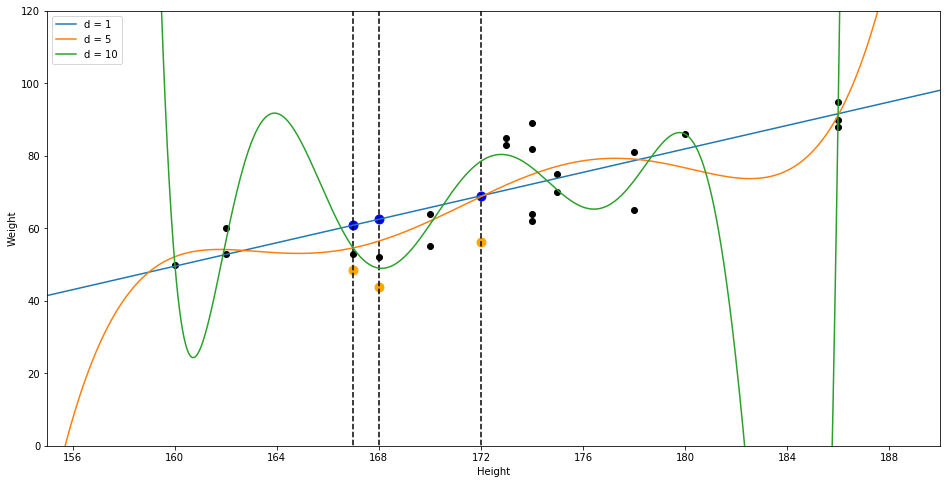

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.linalg import inv, pinv

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

data = np.loadtxt('whData.dat',
                  dtype=np.object,
                  comments='#',
                  delimiter=None)

W = data[:,0].astype('float32')
H = data[:,1].astype('float32')

w_mask = ((W > 0) * 1).nonzero()
pred_mask = ((W < 0) * 1).nonzero()


H_to_predict = H[pred_mask]

W = W[w_mask]
H = H[w_mask]

# to make the code more numerically stable we down-scale it by some 
# large number so that all values are between 0 and 1
scale = 200
W = W/scale
H = H/scale
H_to_predict = np.sort(H_to_predict/scale)

# plot the outliers
for pred in H_to_predict:
    ax.plot([pred, pred], [-10, 10], '--', color='black')

W = W.astype('float64')
H = H.astype('float64')

# solve the solution "zufuss"
# ------------ d = 1 ----------
X = np.vander(H, 1+1)  # (21,2)
y = np.array([W]).T    # (21,1)
w = inv(X.T @ X) @ (X.T @ y)
incl, intercpt = w
ax.plot([0, 200], [incl * 0 + intercpt, incl * 200 + intercpt], 
         label='d = 1')

solve_d1 = lambda x: incl * x + intercpt

# ------------ d = 5 ----------
d = 5
X = np.vander(H, d+1)
y = np.array([W]).T        # (21,1)

# pinv is more numerically stable than the 'naive' implementation above
w = np.squeeze(pinv(X) @ y)  # pinv = (X^T X) X^T
_x_ = np.linspace( 0, 1, 10000)
p_d5 = np.poly1d(w)
ax.plot(_x_, p_d5(_x_), label="d = 5")

# ------------ d = 10 ----------
d = 10
X = np.vander(H, d+1)
y = np.array([W]).T        # (21,1)

# pinv is more numerically stable than the 'naive' implementation above
w = np.squeeze(pinv(X) @ y)  # pinv = (X^T X) X^T
_x_ = np.linspace( 0, 1, 10000)
p_d10 = np.poly1d(w)
ax.plot(_x_, p_d10(_x_), label="d = 10")

# ------------------------------

ax.scatter(H, W, color='black')
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

ax.set_ylim([0/scale, 120/scale])
ax.set_xlim([155/scale, 190/scale])
ax.set_xticklabels([int(x * scale) for x in ax.get_xticks()])
ax.set_yticklabels([int(y * scale) for y in ax.get_yticks()])

print("d=5")
print("\t",H_to_predict*scale)
print("\t",p_d5(H_to_predict)*scale)

print("d=10")
print("\t",H_to_predict*scale)
print("\t",p_d10(H_to_predict)*scale)


ax.scatter(H_to_predict, solve_d1(H_to_predict), color='blue', s=80)
ax.scatter(H_to_predict, p_d5(H_to_predict), color='orange', s=80)
ax.scatter(H_to_predict, p_d10(H_to_predict), color='green', s=80)

plt.legend()
plt.show()

### task 2.2: conditional expectation for missing value prediction

Fit a bi-variate Gaussian to the height and weight data in $x$ and $y$ to model the joint density $p(x,y)$ of heights and weights.

Given your fitted bi-variate Gaussian, use the idea of conditional expectation to predict the weight values for the outliers. That is, let $x_0$ denote the available height data of an outlier and compute 
$$
|\!E \big[ \ y \ \big| \ x_0 \ \big] =
\int y \ p(y | x_0 ) dy
$$

Do this either analytically as discussed in the lecture or numerically and report your results.

---

**Sample Covariance Matrix**: $Q=\frac{1}{n-1}\sum_{i=1}^n \big( 
x_i - \overline{x}\big) (x_i - \overline{x})^T$

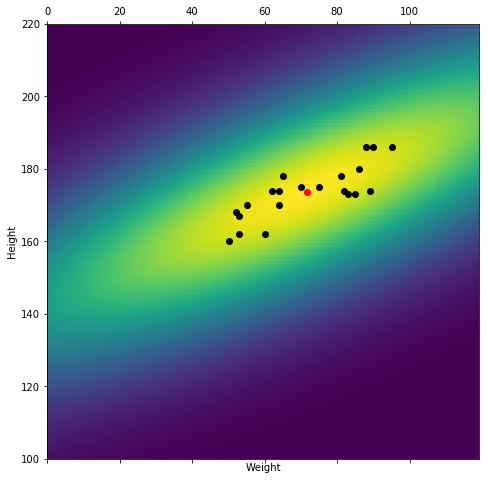

In [76]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.linalg import inv, pinv
from scipy.stats import multivariate_normal

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

data = np.loadtxt('whData.dat',
                  dtype=np.object,
                  comments='#',
                  delimiter=None)

W = data[:,0].astype('float32')
H = data[:,1].astype('float32')
w_mask = ((W > 0) * 1).nonzero()
pred_mask = ((W < 0) * 1).nonzero()

W = W[w_mask]
H = H[w_mask]
H_to_predict = H[pred_mask]

ax.scatter(W, H, color='black')
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
ax.set_ylim([100, 220])
ax.set_xlim([0, 119])

# --------------------------------
# mean
X = np.array([W, H])
mu = np.expand_dims(np.mean(X, 1), 1)  # expand so inner product works
ax.scatter(mu[0], mu[1], color='red')

# cov
Q = (X-mu) @ (X-mu).T

# ---
F = multivariate_normal(np.squeeze(mu), Q)

Im = np.zeros((220, 120))

for i,w in enumerate(range(0, 120)):  # welp, this sucks and could be
    for j,h in enumerate(range(0, 220)):  # better but who cares (I dont)
        Im[j,i] = F.pdf([w, h])

ax.matshow(Im)

# --------------------------------
plt.show()